# Báo cáo bài tập lớn môn Học máy 
**Giảng viên**: Trần Quốc Long

**Lớp môn học:** INT3405E_20

**Sinh viên:** Kiều Văn Tuyên

**MSSV**: 19021388

# MÔ TẢ BÀI TOÁN
* Quora là nền tảng để mọi người có thể học hỏi lẫn nhau bằng cách đặt câu hỏi và trả lời để chia sẻ kiến thức. Mục đích của bài toán này là để phân loại các câu hỏi đặt ra là thuộc loại câu hỏi chân thành hay không chân thành. 
* Những câu hỏi không chân thành thường là những câu đưa ra tuyên bố quan điểm của mình hơn là để tìm những câu trả lời có ích: không trung lập, khiêu khích hoặc chê bai, không có căn cứ thực tế hoặc chứa nội dung khiêu dâm.
* Input: Câu hỏi dạng text
* Output: 0/1 (Sincere/ Insincere)

# PHÂN TÍCH DỮ LIỆU


**Import các thư viện cần thiết:**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from fastai.text.all import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
import seaborn as sns

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline

**1. Khảo sát dữ liệu**

In [ ]:
#Import data
path = "/kaggle/input/quora-insincere-questions-classification/"
train_file = pd.read_csv(path + "train.csv")
test_file = pd.read_csv(path + "test.csv")

print("Train_file: ")
train_file.tail()


In [ ]:
print("Test_file:")
test_file.head()

In [ ]:
train_file.shape, test_file.shape

**Nhận xét:**

**File train.csv:**
* Số dòng: 1306122
* Số cột: 3 (cột qid, question_text, target)

**File test.csv:**
* Số dòng: 375806
* Số cột: 2 (cột qid, question_text)

**Thông tin về các trường:**
* Cột qid: Đây chính là id của câu hỏi, không có 2 câu hỏi nào có id giống nhau.
* Cột question_text: Đây chính là cột chứa các câu hỏi. Chúng ta sẽ tiến hành clean dữ liệu trước khi cho vào mô hình để huấn luyện.
* Cột target: Đây chính là cột chứa kết quả đánh giá câu hỏi có phải chân thành hay không chân thành, câu hỏi question_text có target = 0 sẽ được đánh giá là câu hỏi chân thành, và câu hỏi có target = 1 sẽ được đánh giá là không chân thành.

In [ ]:
#Ta biểu diễn đồ thị tỉ lệ số câu hỏi chân thành và số câu hỏi không chân thành trong tập train

sincere_ques = train_file[train_file.target == 0]
insincere_ques = train_file[train_file.target == 1]

label = 'sincere', 'Insincere'
size = [(sincere_ques.shape[0] / train_file.shape[0]) * 100, (insincere_ques.shape[0] / train_file.shape[0]) * 100]
plt.pie(size,labels = label,colors=["c", "red"], autopct="%.2f%%")
plt.axis('equal')
plt.show()

In [ ]:
print("Tổng số dữ liệu trong tập train: ",train_file.shape[0])
print("Số câu hỏi chân thành: ", len(train_file[train_file.target == 0]))
print("Số câu hỏi thiếu chân thành: ",len(train_file[train_file.target == 1]))

**Nhận xét về phân lớp dữ liệu:**

Dựa vào biểu đồ trên, ta có thể thấy trong tập train, số lượng câu hỏi đc đánh nhãn là thiếu chân thành chỉ chiếm khoảng 6.19% (80810/1306122 câu) so với tỉ lệ rất cao là 93.81% là những câu hỏi chân thành.

Tỉ lệ giữa 2 nhóm câu hỏi này rơi vào khoảng 1:15 => Tập dữ liệu bị mất cân bằng. Điều này sẽ dẫn đến 1 số vấn đề như sau:
* Đánh giá sai chất lượng mô hình: Với tỉ lệ như trên thì không cần quan tâm đến mô hình ta cũng có thể đạt được độ chính xác cao của metric accuracy, chỉ cần tất cả dự đoán đưa ra đều có target = 0 thì độ chính xác đã đạt gần 94%.
* Mô hình dự đoán kém chính xác: Vì ở đây, mục tiêu của bài toán là xác định các câu hỏi thiếu chân thành, trong khi sự mất cân bằng trên có thể khiến kết quả dự đoán thường nghiêng về nhóm đa số(target = 0) và kém hiệu quả trên nhóm thiểu số (target = 1).

 Do đó không nên lựa chọn độ chính xác(accuracy) làm chỉ số đánh giá mô hình. Thay vào đó ta có thể sử dụng các metric thay thế như: **F1_score, Recall,..**

**Khảo sát về tần suất các từ xuất hiện trong tập dữ liệu:**
* **Word clouds**: Hoạt động theo một các đơn giản: Một từ càng xuất hiện nhiều trong văn bản thì từ đó càng lớn và đậm nét hơn trong Word clouds.

In [ ]:
print('Ảnh word cloud được tạo từ những câu hỏi chân thành:')
sincere_wordcloud = WordCloud(width=600, height=400, background_color ='black', min_font_size = 10).generate(str(train_file[train_file["target"] == 0]["question_text"]))
#Positive Word cloud
plt.figure(figsize=(15,6), facecolor=None)
plt.imshow(sincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

In [ ]:
print('Ảnh word cloud được tạo từ những câu hỏi thiếu chân thành:')
insincere_wordcloud = WordCloud(width=600, height=400, background_color ='white', min_font_size = 10).generate(str(train_file[train_file["target"] == 1]["question_text"]))
#Positive Word cloud
plt.figure(figsize=(15,6), facecolor=None)
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

**Thống kê những từ phổ biến trong các loại câu hỏi ( loại bỏ các stopwords)**

**Stop Words:** Là những từ thường được sử dụng ( chẳng hạn như 'the', 'an', 'a',..). Để tránh những từ này chiếm dung lượng trong cơ sở dữ liệu hoặc mất thời gian xử lí, chúng ta nên loại bỏ chúng.

Thống kê Word clouds ở trên có thể có những stop words, do đó ta cần lọc chúng ra để có một cái nhìn tổng quan hơn


In [ ]:


stop_words = set(stopwords.words('english'))
stop_words

In [ ]:
class Vocabulary(object):
    # Tham khảo tại:https://www.kaggle.com/kaosmonkey/visualize-sincere-vs-insincere-words
    def __init__(self):
        self.vocab = {}
        self.STOPWORDS = set()
        self.STOPWORDS = set(stopwords.words('english'))
    def build_vocab(self, lines):
        for line in lines: 
            for word in line.split(' '):
                word = word.lower()
                if(word in self.STOPWORDS):
                    continue
                if(word not in self.vocab):
                    self.vocab[word] = 0
                self.vocab[word] += 1
                

In [ ]:
#Vơi các câu hỏi chân thành
sincere_vocab = Vocabulary()
sincere_vocab.build_vocab(train_file[train_file['target'] == 0]['question_text'])
sincere_vocabulary = sorted(sincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
# Dùng sns vẽ biểu đồ 10 từ có tần suất xuất hiện cao nhất
for word, count in sincere_vocabulary[:10]:
    print(word, count)
df_sincere_vocab = pd.DataFrame(sincere_vocabulary,columns = ['word_sincere', 'frequency'])
sns.barplot(x = 'word_sincere', y = 'frequency', data = df_sincere_vocab[:10])


In [ ]:
# Tuong tu voi cac cau hoi khong chan thanh
insincere_vocab = Vocabulary()
insincere_vocab.build_vocab(train_file[train_file['target'] == 1]['question_text'])
insincere_vocabulary = sorted(insincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
for word, count in insincere_vocabulary[:10]:
    print(word, count)
df_insincere_vocab = pd.DataFrame(insincere_vocabulary,columns = ['word_insincere', 'frequency'])
sns.barplot(y = 'word_insincere', x = 'frequency', data = df_insincere_vocab[5:25])


**Nhận xét:**
Như chúng ta có thể thấy rõ ràng là có  một số từ phản cảm (nội dung khiêu dâm, phân biệt chủng tộc, nhân vật chính trị,..) xuất hiện rất nhiều trong các câu hỏi thiếu chân thành.

# Text Processing

Sau khi đánh giá, ta thấy dữ liệu còn khá phức tạp và nhiễu. Để đơn giản hóa dữ liệu, ta cần tiến hành xử lý dữ  liệu 
bằng một số bước như: Chỉ giữ lại các ký tự chữ và số, loại bỏ các stop word, đưa các từ về đúng dạng gốc,...

**Tokenization :** (tách từ) là một trong những bước quan trọng nhất trong quá trình tiền xử lý văn bản. Nói một cách đơn giản,
tokenization là quá trình tách một cụm từ, câu, đoạn văn, một hoặc nhiều tài liệu văn bản thành các đơn vị nhỏ hơn. Mỗi đơn vị 
nhỏ hơn này được gọi là Tokens.

**Stemming vs. lemmatization:** Với mục đích là giảm các dạng vô hướng của mỗi từ thành một cơ sở hoặc gốc chung.

Stemming là kĩ thuật dùng để biến đổi 1 từ về dạng gốc( được gọi là stem hoặc root form) bằng cách cực kỳ đơn giản là loại bỏ 1 số
ký tự nằm ở cuối từ mà nó nghĩ rằng là biến thể của từ. 
Ví dụ như chúng ta thấy các từ như walked, walking, walks chỉ khác nhau là ở
những ký tự cuối cùng, bằng cách bỏ đi các hậu tố -ed, -ing hoặc -s, chúng ta sẽ được từ nguyên gốc là walk. Tuy nhiên stemming 
không thể đưa được các động từ bất quy tắc về dạng gốc được.

Khác với Stemming là xử lý bằng cách loại bỏ các ký tự cuối từ một cách rất heuristic, Lemmatization sẽ xử lý thông minh hơn bằng một bộ
từ điển hoặc một bộ ontology nào đó. 
Điều này sẽ đảm bảo rằng các từ như “goes“, “went” và “go” sẽ chắc chắn có kết quả trả về là như nhau.
Kể các từ danh từ như mouse, mice cũng đều được đưa về cùng một dạng như nhau. 





In [ ]:
train_file = train_file[['question_text', 'target']]
# def text_processing(data_file):
#     stemmer = PorterStemmer()
#     #Thực hiện processing:
#     data_file['txt_processed'] = data_file['question_text'].apply(lambda train_file: word_tokenize(train_file))
#     print('step1 done...')
#     data_file['txt_processed'] = data_file['txt_processed'].apply(lambda x: [item for item in x if item.isalpha()])
#     print('step2 done..')
#     data_file['txt_processed'] = data_file['txt_processed'].apply(lambda x: [item for item in x if item not in stop_words])
#     print('step3 done..')
#     data_file['txt_processed'] = data_file['txt_processed'].apply(lambda x: [stemmer.stem(item) for item in x])
#     print('done')
#     return data_file

In [ ]:
# train_file_sw = text_processing(train_file)
# train_file_sw.tail()

In [ ]:
# Không tách stop word
def text_processing_nosw(data_file):
    stemmer = PorterStemmer()
    #Thực hiện processing:
    data_file['txt_processed'] = data_file['question_text'].apply(lambda train_file: word_tokenize(train_file))
    print('step1 done...')
    data_file['txt_processed'] = data_file['txt_processed'].apply(lambda x: [item for item in x if item.isalpha()])
    print('step2 done..')
    data_file['txt_processed'] = data_file['txt_processed'].apply(lambda x: [stemmer.stem(item) for item in x])
    print('done')
    return data_file

In [ ]:
train_file_nw = text_processing_nosw(train_file)
train_file_nw.tail()

**Nhận xét:** 
* 
Không tách stop words giúp kết quả f1_scored cao hơn dù không nhiều, đối với CountVectorizer + Logistic Regression kết quả f1_score tăng từ 0.62 (đã chạy ở version 5) lên 0.64

# Huấn luyện Model

**Metric: F-score**

Metric phù hợp nhất trong bài này sẽ là f1-scored

**Precision và Recall**
* Precision của lớp A:Là số lượng mẫu đoán đúng là A / số lượng mẫu đoán là A
\begin{align*}p &=\frac{TP}{TP + FP}\\\\ &=\frac{\sum_{i=1}^n \mathbb I(y_i = h(x_i) = A)}{\sum_{i=1}^n \mathbb I(h(x_i) = A)}\end{align*}

* Recall của lớp A: Là số lượng mẫu đoán đúng là A / số lượng mẫu là A:
\begin{align*}r &= \frac{TP}{TP + FN}\\\\&= \frac{\sum_{i =1}^n \mathbb{I}(y_i = h(x_i) = A)}{\sum_{i = 1}^n \mathbb{I}(y_i = A)}\end{align*}

Tuy nhiên, chỉ có Precision hay chỉ có Recall thì không đánh giá được chất lượng mô hình.
* Chỉ dùng Precision, mô hình chỉ đưa ra dự đoán cho một điểm mà nó chắc chắn nhất. Khi đó Precision = 1, tuy nhiên ta không thể nói là mô hình này tốt.
* Chỉ dùng Recall, nếu mô hình dự đoán tất cả các điểm đều là positive. Khi đó Recall = 1, tuy nhiên ta cũng không thể nói đây là mô hình tốt

Khi đó F1-score được sử dụng. F1-score là trung bình điều hòa (harmonic mean) của precision và recall (giả sử hai đại lượng này khác 0). F1-score được tinh theo công thức:

  ![](https://obrunet.github.io/images/2019-09-16-Quora/f1.png)





In [ ]:
# Hàm tính fscore của model
def get_fscore_matrix(fitted_clf, model_name):
    print(model_name, ' :')
    
    # get classes predictions for the classification report 
    y_train_pred, y_pred = fitted_clf.predict(X_train), fitted_clf.predict(X_test)
    print(classification_report(y_test, y_pred), '\n') # target_names=y
    
    # computes probabilities keep the ones for the positive outcome only      
    print(f'F1-score = {f1_score(y_test, y_pred):.2f}')

**Model sử dụng: Logicstic Regression**
* Trong thư viện **Sklearn** cũng có hỗ trợ mô hình Logicstics, nên ta sẽ dùng vào bài toán.
* Về Logicstic Regression, có thể xem tham khảo tại: https://tricky-tax-444.notion.site/02-H-i-quy-Logistics-cf099245442c461aa36305456a17183e

**Cách tiếp cận đầu tiên: TF-IDF (Term Frequency - Inverse Document Frequency)**
* **TF-IDF (Term Frequency – Inverse Document Frequency)** là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản, giúp đánh trọng số cho mỗi từ trong văn bản, trong đó TF là tần số xuất hiện của từ trong văn bản và idf là tần số nghịch giúp làm giảm giá trị của những từ phổ biến.Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu.

* **TF: Term Frequency(Tần suất xuất hiện của từ)**: là số lần từ xuất hiện trong văn bản.Vì các văn bản có thể có độ dài ngắn khác nhau nên một số từ có thể xuất hiện nhiều lần trong một văn bản dài hơn là một văn bản ngắn. Như vậy, term frequency thường được chia cho độ dài văn bản( tổng số từ trong một văn bản).

* **IDF: Inverse Document Frequency(Nghịch đảo tần suất của văn bản)** : giúp đánh giá tầm quan trọng của một từ. Khi tính toán TF , tất cả các từ được coi như có độ quan trọng bằng nhau. Nhưng một số từ như “a”, “the” và “that” thường xuất hiện rất nhiều lần nhưng độ quan trọng là không cao. Như thế chúng ta cần giảm độ quan trọng của những từ này xuốn

* Khi đó, những từ có giá trị tf-idf cao là những từ xuất hiện nhiều trong câu này, và xuất hiện ít trong  câu khác. Việc này giúp ta lọc ra được những từ phổ biến và giữ lại những từ có giá trị cao ( từ khóa của câu đó )



In [ ]:


vectorizer = TfidfVectorizer(lowercase=False, analyzer=lambda x: x, min_df=0.01, max_df=0.999)
tf_idf = vectorizer.fit_transform(train_file_nw['txt_processed']).toarray()

tf_idf = vectorizer.fit_transform(train_file_nw['txt_processed']).toarray()
# Split the data (Bộ dữ liệu train_file sẽ được chia ra như sau: 80% tập dữ liệu sẽ được dùng để huấn luyện, và 20% còn lại sẽ được dùng để test.)
X_train, X_test, y_train, y_test = train_test_split(tf_idf, train_file_nw['target'], test_size=0.2, random_state=42)


#Use logictics
model = LogisticRegression(class_weight={0:y_train.sum(), 1:len(y_train) - y_train.sum()}, C=30, max_iter=200, n_jobs=-1)
model.fit(X_train, y_train)
get_fscore_matrix(model, 'LogisticRegression')

Như có thể thấy ở trên, nếu chỉ dùng TF-IDF kết hợp với Logicstic Regression, kết quả cho ra khá thấp, chỉ là 0.3

**Cách tiếp cận khác: a CountVectorizer / Logistic Regression**

Để sử dụng dữ liệu văn bản cho mô hình dự đoán, văn bản phải được phân tích cú pháp để loại bỏ một số từ nhất định - quá trình này được gọi là mã hóa. Sau đó, những từ này cần được mã hóa dưới dạng số nguyên hoặc giá trị dấu phẩy động, để sử dụng làm đầu vào trong các thuật toán học máy. Quá trình này được gọi là feature extraction (hay vectorization).

**CountVectorizer** được sử dụng để chuyển đổi một tập hợp các tài liệu văn bản thành một vectơ có số lượng từ khóa / mã thông báo. Nó cũng cho phép xử lý trước dữ liệu văn bản trước khi tạo biểu diễn vectơ. Chức năng này làm cho nó trở thành một mô-đun biểu diễn tính năng rất linh hoạt cho văn bản. Ví dụ minh họa như hình dưới đấy

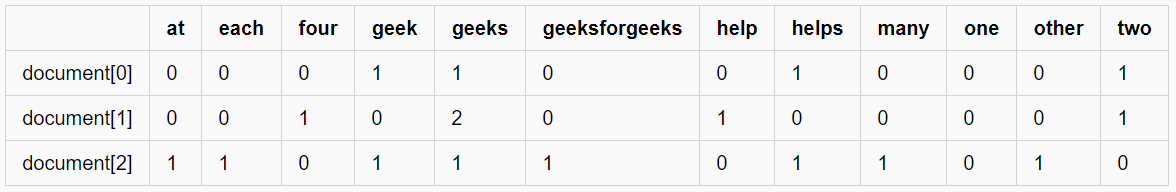

Đầu tiên, để thực hiện ta cần nối các từ đã tách ở txt_processed thành một chuỗi

In [ ]:
# Convert a collection of text documents to string
train_file_nw['str_processed'] = train_file_nw['txt_processed'].apply(lambda x: " ".join(x))
train_file_nw.head()

**Sử dụng Pipeline**

In [ ]:

pipeline = Pipeline([("cv", CountVectorizer(analyzer="word", ngram_range=(1,4), max_df=0.9)),
                     ("clf", LogisticRegression(solver="saga", class_weight="balanced", C=0.5, max_iter=250, verbose=1, n_jobs=-1))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_file_nw['str_processed'], train_file_nw.target, test_size=0.2, stratify = train_file_nw.target.values)

In [ ]:
pl_model = pipeline.fit(X_train, y_train)
pl_model

In [ ]:
get_fscore_matrix(pl_model, 'Pipeline:')

**Kết luận:**
* Đầu tiên ta sử dụng TF-IDF, nhưng chúng ta có thể thấy là nó thực sự không hiệu quả.
* Thay vào đó, sử dụng CountVectorizer với Logistic Regression là hiệu quả hơn rất nhiều 


**Submission**

In [ ]:
pd.read_csv("../input/quora-insincere-questions-classification/sample_submission.csv").head()

In [ ]:
test_file = text_processing_nosw(test_file)
test_file['str_processed'] = test_file['txt_processed'].apply(lambda x: " ".join(x))
test_file.head()



In [ ]:
y_pred_final = pl_model.predict(test_file['str_processed'])
df_submission = pd.DataFrame({"qid":test_file["qid"], "prediction":y_pred_final})
df_submission.head()

In [ ]:
df_submission.to_csv('submission.csv', index=False)

# Training model sử dụng pretrained BERT

Như đã có ở kết quả ở trên, điểm f1_score là 0.64, cũng khá ổn. Tuy nhiên, ta sẽ thử cải thiện kết quả này bằng cách sử dụng BERT - một mô hình rất mạnh

**Giới thiệu về BERT**

Cuối năm 2018, các nhà nghiên cứu làm việc tại Google AI giới thiệu một một kiến trúc mới cho lớp bài toán Language Representation: BERT - viết tắt của Bidirectional Encoder Representations from Transformers. Đây là mô hình được huấn luyện trước từ các văn bản không được gán nhãn.

Điểm khác biệt lớn nhất so với các mô hình đã có trước đó là mô hình BERT mới này được thiết kế để biểu diễn ngôn ngữ bằng cách xem xét ngữ cảnh 2 chiều cả bên trái và bên phải.  Sau đó, vector biểu diễn ngôn ngữ có thể được tinh chỉnh (bằng một lớp đầu ra bổ sung), ứng dụng cho một loạt các nhiệm vụ, đặc biệt không yêu cầu sửa đổi quá nhiều kiến trúc để phục vụ cho bài toán mới. Điều này góp phần cải thiện hiệu quả khi sử dụng biểu diễn ngôn ngữ được huấn luyện trước cho các tác vụ về sau theo hướng tiếp cận fine-tuning.

Sau đây, ta sẽ áp dụng BERT vào bài toán đã cho.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
class QuoraDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.text = X.reset_index(drop=True)
        self.targets = y.reset_index(drop=True)
        self.tok = tokenizer
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        
        text = self.text[idx]
        targ = self.targets[idx]
        
        return self.tok(text, padding='max_length', 
                        truncation=True,
                        max_length=30,
                        return_tensors="pt")["input_ids"][0], tensor(targ)

In [ ]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(train_file["question_text"], train_file["target"], 
                                                      stratify=train_file["target"],  test_size=0.1)

In [ ]:
train_ds = QuoraDataset(X_train, y_train, tokenizer) # train dataset
valid_ds = QuoraDataset(X_valid, y_valid, tokenizer) # valid dataset

In [ ]:
# Prepare data loader
train_dl = DataLoader(train_ds, bs=128)
valid_dl = DataLoader(valid_ds, bs=256)
data_loader = DataLoaders(train_dl, valid_dl).to("cuda")

In [ ]:
# Sử dụng BERT model

bert = AutoModelForSequenceClassification.from_pretrained('bert-base-cased').train()
classifier = nn.Sequential(
    nn.Linear(768, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2)
)
bert.classifier = classifier
class BertClassifier(Module):
    def __init__(self, bert):
        self.bert = bert
    def forward(self, x):
        x = self.bert(x)
        return x.logits

model = BertClassifier(bert).to("cuda")

In [ ]:

num_sin = (train_file["target"] == 0).sum() # số câu hỏi chân thành
num_insin = (train_file["target"] == 1).sum() # Số câu hỏi không chân thành
n = num_sin + num_insin
class_weights = tensor([n / (n+num_sin), n / (n+num_insin)]).to('cuda')
learn = Learner(data_loader, model, 
                loss_func=nn.CrossEntropyLoss(weight=class_weights), 
                metrics=[accuracy, F1Score()]).to_fp16()
learn.lr_find() # Biểu thị bảng learning rate


Ở đây,ta sẽ sử dụng lr.find() để tìm learning rate cho hợp lý. Như đã thấy ở biểu đồ trên thì ở khoảng 0.001 và 0.01  là khá tốt, có giá trị loss thấp. Do đó ta sẽ chọn learning rate = 2e^-5 ( xấp xỉ = 0.01) để train mô hình.

In [ ]:
learn.fit_one_cycle(2, lr_max=2e-5)

**Nhận xét:** 
* Dùng model BERT đem lại kết quả f1_scored cao hơn so với việc sử dụng CountVectorizer + Logistic Regression
* Đặc biệt là ta không cần phải xử lí dữ liệu trước khi tiến hành train, vì BERT đã thay ta làm điều đó r.
* Tuy nhiên, trong cuộc thi này ta không được phép sử dụng các dữ liệu bên ngoài. Vì thế việc chạy thử BERT chỉ mang tính chất nhận xét về sức mạnh của nó.

# Báo cáo kết quả
1. Đối với CountVectorizer và Logistic Regression: Kết quả khi submit đạt cao nhất là 0.63691 đối với Private score và đạt 0.63 đối với public score

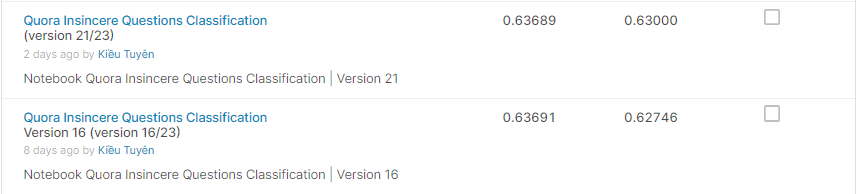

2. Sử dụng Bert model: điểm F1_score đạt cao nhất là 0.719. ( ở version 22 )